## STORE SALES FORECAST USING REGRESSION MODEL
#### Business Understanding
##### **Introduction**
Accurate sales forecasting is crucial for maximizing inventory management, resource allocation, and decision-making in the dynamic retail sector. This project focuses on time series forecasting for store sales, aiming to create a robust predictive model for Corporation Favorita, a leading grocery retailer in Ecuador. By leveraging data and advanced analytics, this initiative seeks to enhance Favorita's operations, boost customer satisfaction, and drive business growth.

##### **Business Objective**
The primary objective of this project is to develop a robust and accurate time series forecasting model that predicts store sales for various products across Favorita stores. Utilizing historical sales data and relevant supplementary information, the model aims to provide reliable forecasts, enabling Favorita to optimize inventory management, resource allocation, and marketing strategies. The successful implementation of this model will lead to improved operational efficiency, enhanced decision-making, and increased profitability for the retailer.

##### **Business Goals**
- Improve Inventory Management: Accurate sales predictions will enable Favorita to manage inventory levels efficiently, reducing stockouts and overstock situations.

- Enhance Resource Allocation: Precise sales forecasts will allow Favorita to allocate human resources and logistics more effectively, ensuring adequate staffing and supplies to meet customer demand.

- Marketing and Promotion Strategies: Understanding the impact of promotions on sales will help Favorita tailor its marketing strategies to boost sales during specific periods.

- Optimized Financial Planning: Accurate sales predictions will facilitate better financial planning and budgeting, contributing to the retailer's overall financial health.
##### **Key Stakeholders**

Stakeholders include Corporation Favorita's management, sales and marketing teams, store managers, and data science team.

##### **Success Criteria**

- Achieve a 0.2 RMSE (Root Mean Squared Error) in sales forecasting models.
- Improve inventory management efficiency and reduce stockout instances.

##### **Data Requirements**

- Historical Sales Data: Detailed sales records over a significant period.
- Transaction Data: Information on individual transactions, including date, time, and items purchased.
- Store Metadata: Details about each store, including location, size, and demographics.
- Oil Price Data: Historical oil price data to consider its impact on sales, as it can affect transportation costs and     consumer spending.
- Holidays and Events Data: Information on holidays and special events that may influence sales patterns.

**File Descriptions and Data Field Information**

- **train.csv**: The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.

- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

- **test.csv**: The test data, having the same features as the training data.This  will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

- **transaction.csv**:Contains date, store_nbr and transaction made on that specific date.
sample_submission.csv
A sample submission file in the correct format.
- **Stores.csv**: Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

- **oil.csv**:
Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

- **holidays_events.csv**:
Holidays and Events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


##### **Hypothesis**
**Null Hypothesis (Ho)**: Holidays do not have a significant effect on the sales

**Alternate Hypothesis (Ha)**: Holidays have a significant effect on the sales


##### Analytical Questions

- Is the train dataset complete (has all the required dates)?
- Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
- Compare the sales for each month across the years and determine which month of which year had the highest sales.
- Did the earthquake impact sales?
- Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
- Are sales affected by promotions, oil prices and holidays?
- What analysis can we get from the date and its extractable features?
- Which product family and stores did the promotions affect.
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
- Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.





#### Data Understanding
**Importations**

In [2]:
import pyodbc    
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings 
import seaborn as sns

warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle



**Loading the Datasets**

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials  set in the '.env' file
server = environment_variables.get("server_name")
database = environment_variables.get("database_name")
username = environment_variables.get("user")
password = environment_variables.get("password")


In [4]:
#create a connection string to the database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"


In [5]:
# Use the connect method of the pyodbc library and pass in the connection string.
connection = pyodbc.connect(connection_string)


In [6]:
# write an sql query to get data

query = '''SELECT *
           FROM INFORMATION_SCHEMA.TABLES
            WHERE TABLE_TYPE = 'BASE TABLE'
        '''
data = pd.read_sql(query, connection)
data.head()


TABLE_CATALOG TABLE_SCHEMA       TABLE_NAME  TABLE_TYPE
0         dapDB          dbo  holidays_events  BASE TABLE
1         dapDB          dbo              oil  BASE TABLE
2         dapDB          dbo           stores  BASE TABLE

In [7]:
# write an sql query to get data from the holiday_events table and parse_date to convert date column to datetime datatype
query = '''SELECT *
           FROM holidays_events
        '''
df_1 = pd.read_sql(query, connection, parse_dates= ['date'])

#preview the data
df_1.head()


date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [8]:
#write an sql query to get data from the oil table
query = '''SELECT *
           FROM oil
        '''
df_2 = pd.read_sql(query, connection, parse_dates=['date'])

#preview the data
df_2.head()


date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02   93.139999
2 2013-01-03   92.970001
3 2013-01-04   93.120003
4 2013-01-07   93.199997

In [9]:
#write an sql query to get data from the stores table
query = '''SELECT *
           FROM stores
        '''
df_3 = pd.read_sql(query, connection)

#view the data
df_3.head()


store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [10]:
#load the csv file
df_4 = pd.read_csv(r'train.csv',parse_dates=['date'])

#view the data
df_4.head()


id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [11]:
#load the csv file
df_5 = pd.read_csv(r'transactions.csv', parse_dates=['date'])

#view the data
df_5.head()


date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

##### **Exploratory Data Analysis and Data Cleaning for Different datasets** #####
**Data Quality Assessment**



**Checking the column information**

In [12]:
# Create a dictionary with dataframe names and dataframes
dfs = {
    "Holiday Dataset": df_1,
    "Oil Dataset": df_2,
    "Stores Dataset": df_3,
    "Train Dataset": df_4,
    "Transaction Dataset": df_5
}


# Define the function to print column info for each dataframe
def check_column_info(dfs):
    for name, df in dfs.items():
        # Print the name of the dataframe
        print(f"DataFrame: {name}")
        # Print the column info of the dataframe
        print(df.info())
        print("\n")


# Call the function to print column info for each dataframe
check_column_info(dfs)

DataFrame: Holiday Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB
None


DataFrame: Oil Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None


DataFrame: St

- columns with object datatype will be converted to category to optimize memory usage after merging the datasets.


In [13]:
# # Visualizing the 'dcoilwtico' column to Identify a Strategy for Handling Missing dates
# fig = px.line(df_2, x='date', y='dcoilwtico')
# fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
# fig.update_xaxes(rangeslider_visible=True)
# fig.show()

**Checking for Duplicates**

In [14]:

# Define the function to check for duplicates in each dataframe
def check_duplicates(dfs):
    for name, df in dfs.items():
        # Print the name of the dataframe
        print(f"DataFrame: {name}")
        # Check for duplicates and print the results
        duplicate_count = df.duplicated().sum()
        print(f"Total duplicate rows: {duplicate_count}")
        print("\n")

# Call the function to check for duplicates in each dataframe
check_duplicates(dfs)


DataFrame: Holiday Dataset
Total duplicate rows: 0


DataFrame: Oil Dataset
Total duplicate rows: 0


DataFrame: Stores Dataset
Total duplicate rows: 0


DataFrame: Train Dataset
Total duplicate rows: 0


DataFrame: Transaction Dataset
Total duplicate rows: 0




- All datasets do not have duplicates. 

**Set date as index in all datasets**

In [15]:

# define a function to set the 'date' column as index if it exists
def set_date_index(dfs):
    for name, df in dfs.items():
        if 'date' in df.columns:
            df.set_index('date', inplace=True)
            print(f"DataFrame: {name} - 'date' column set as index")
        else:
            print(f"DataFrame: {name}" )
        print(df.head())
        print("\n")


# Call the function to set 'date' column as index if it exists
set_date_index(dfs)


DataFrame: Holiday Dataset - 'date' column set as index
               type    locale locale_name                    description  \
date                                                                       
2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False  
2012-04-12        False  
2012-04-14        False  
2012-04-21        False  


DataFrame: Oil Dataset - 'date' column set as index
            dcoilwtico
date                  
2013-01-01         NaN
2013-01-02   93.139999
2013-01-03   92.970001
2013-01-04   93.120003
2013-01-07   93.199997


DataFrame: S

**Checking for missing values**

In [16]:

# Define the function to check for missing values in each dataframe
def check_missing_values(dfs):
    for name, df in dfs.items():
        # Print the name of the dataframe
        print(f"DataFrame: {name}")
        # Check for missing values and print the results
        missing_values = df.isnull().sum()
        total_missing = missing_values.sum()
        print(f"Total missing values: {total_missing}")
        print(missing_values)
        print("\n")

# Call the function to check for missing values in each dataframe
check_missing_values(dfs)


DataFrame: Holiday Dataset
Total missing values: 0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


DataFrame: Oil Dataset
Total missing values: 43
dcoilwtico    43
dtype: int64


DataFrame: Stores Dataset
Total missing values: 0
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


DataFrame: Train Dataset
Total missing values: 0
id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


DataFrame: Transaction Dataset
Total missing values: 0
store_nbr       0
transactions    0
dtype: int64




- Only the Oil dataset has 43 missing values in the dcoilwtico column. We will analyze the oil dataset (df_2) further and determine the best strategy to handle the missing values.

**Handling the missing values in oil dataset**

In [17]:
#Preview the Oil dataset
df_2.head(20)

dcoilwtico
date                  
2013-01-01         NaN
2013-01-02   93.139999
2013-01-03   92.970001
2013-01-04   93.120003
2013-01-07   93.199997
2013-01-08   93.209999
2013-01-09   93.080002
2013-01-10   93.809998
2013-01-11   93.599998
2013-01-14   94.269997
2013-01-15   93.260002
2013-01-16   94.279999
2013-01-17   95.489998
2013-01-18   95.610001
2013-01-21         NaN
2013-01-22   96.089996
2013-01-23   95.059998
2013-01-24   95.349998
2013-01-25   95.150002
2013-01-28   95.949997

- From the data overview, the first value is missing and others show almost same oil prices for two days, it would be appropriate to use backward fill to address the missing value.

In [18]:
# fill the missing value using the backfill 
# Use interpolation to fill missing values in the specified column
df_2["dcoilwtico"] = df_2["dcoilwtico"].interpolate(method='time')


df_2["dcoilwtico"].fillna(method= "bfill",inplace=True)

In [19]:
# Check for missing values after handling
missing_values_later = df_2['dcoilwtico'].isnull().sum()
print(missing_values_later)

df_2.head(20)

0


dcoilwtico
date                  
2013-01-01   93.139999
2013-01-02   93.139999
2013-01-03   92.970001
2013-01-04   93.120003
2013-01-07   93.199997
2013-01-08   93.209999
2013-01-09   93.080002
2013-01-10   93.809998
2013-01-11   93.599998
2013-01-14   94.269997
2013-01-15   93.260002
2013-01-16   94.279999
2013-01-17   95.489998
2013-01-18   95.610001
2013-01-21   95.969997
2013-01-22   96.089996
2013-01-23   95.059998
2013-01-24   95.349998
2013-01-25   95.150002
2013-01-28   95.949997

**Exploring the Datasets**

**Holiday Events Dataset**

In [20]:
#check the date range
df_1.index.min(),df_1.index.max()

(Timestamp('2012-03-02 00:00:00'), Timestamp('2017-12-26 00:00:00'))

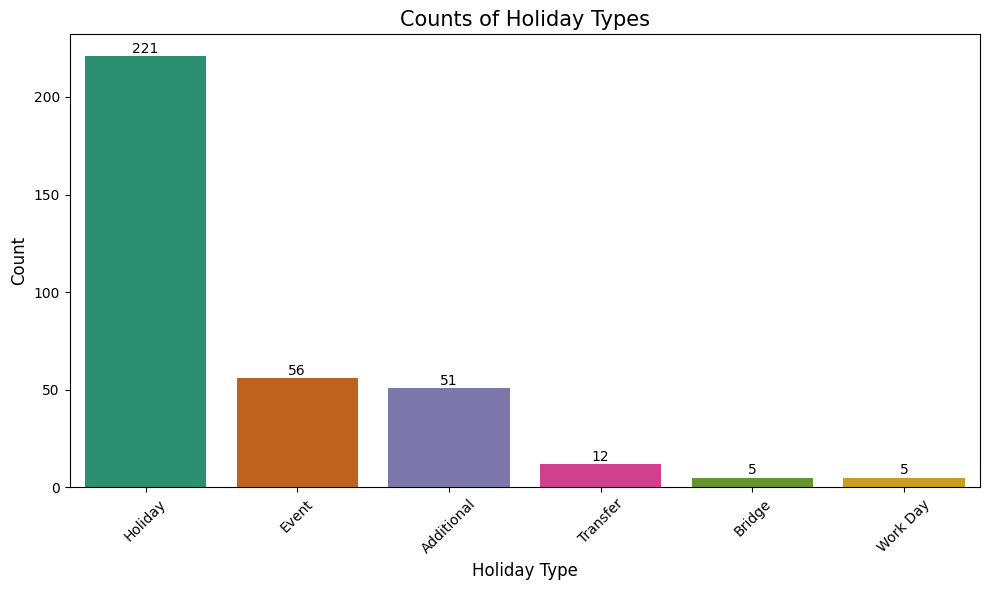

In [21]:
# Value counts of the "type" column
holiday_types = df_1["type"].value_counts()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=holiday_types.index, y=holiday_types.values, palette="Dark2")

# Add values on top of bars
for index, value in enumerate(holiday_types.values):
    bar_plot.text(index, value + 0.05, str(value), ha='center', va='bottom')

plt.title('Counts of Holiday Types', fontsize=15)
plt.xlabel('Holiday Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


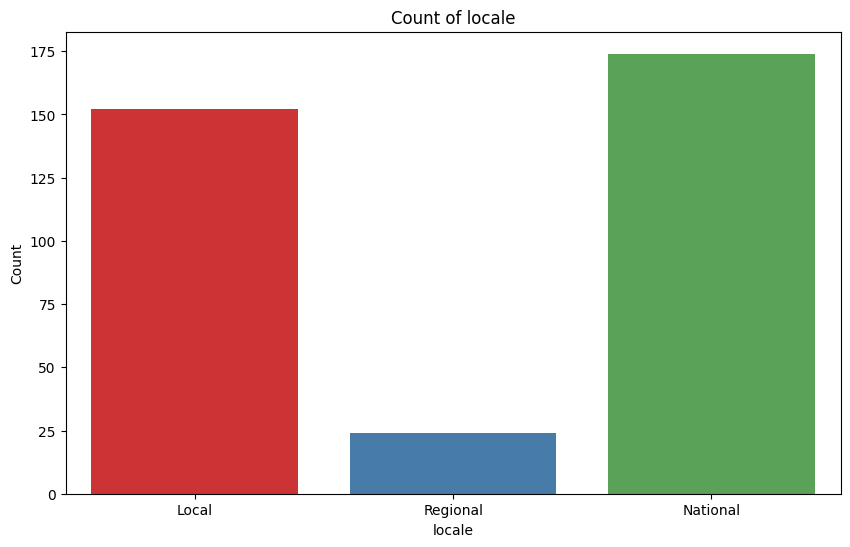

In [22]:
#Explore locale column to see which locale has the highest number of holidays
plt.figure(figsize=(10, 6))  
sns.countplot(df_1, x="locale", palette="Set1")
plt.title(f'Count of {"locale"}')
plt.xlabel("locale")
plt.ylabel('Count')
plt.show()

**Exploring the transferred columns**

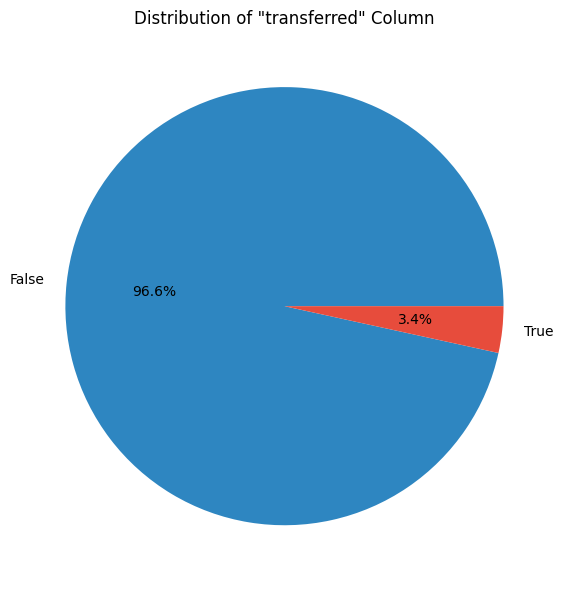

In [23]:
#Get the value counts of the "transferred" column
transferred_counts = df_1["transferred"].value_counts()

#Create a pie chart using matplotlib
plt.figure(figsize=(6, 6))
plt.pie(transferred_counts, labels=transferred_counts.index,  colors=['#2E86C1', '#E74C3C'], autopct='%1.1f%%')
plt.title('Distribution of "transferred" Column')
plt.tight_layout()

plt.show()

- Insights
- National holidays make up the majority of the holidays.
- Most holidays were celebrated on their actual occurrence date.
- Only 12 holidays were marked as transferred, with the rest not being transferred.


**Exploring the Oil Dataset**

In [24]:
#Checking range of dates
df_2.index.min(),df_2.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [25]:
#plot  oil time series 
fig = px.line(df_2, x=df_2.index, y='dcoilwtico',title='Oil Time Series')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

- Observations:
- The oil prices start relatively high in early 2013 and remails relatively stable with some fluctuations to mid 2014.
- Late 2014 to Early 2016: There is a significant downward trend, indicating a sharp decline in oil prices.
- Post-2016: After the decline, the prices stabilize at a lower level with minor fluctuations, staying mostly between 40 and 54

**Exploring the store dataset**

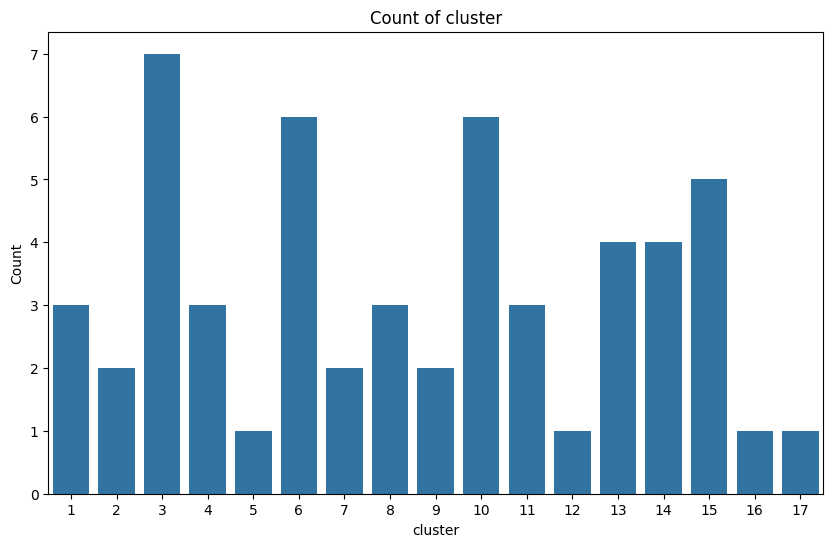

In [26]:
#exploring the cluster column which is a group of similar stores
plt.figure(figsize=(10, 6)) 
sns.countplot(data=df_3, x="cluster")
plt.title(f'Count of {"cluster"}')
plt.xlabel("cluster")
plt.ylabel('Count')
plt.show()

- Cluster 3 has the highest count, with more than 45,000 data points.
- This indicates that Cluster 3 is the most populated cluster.

**Store type column**

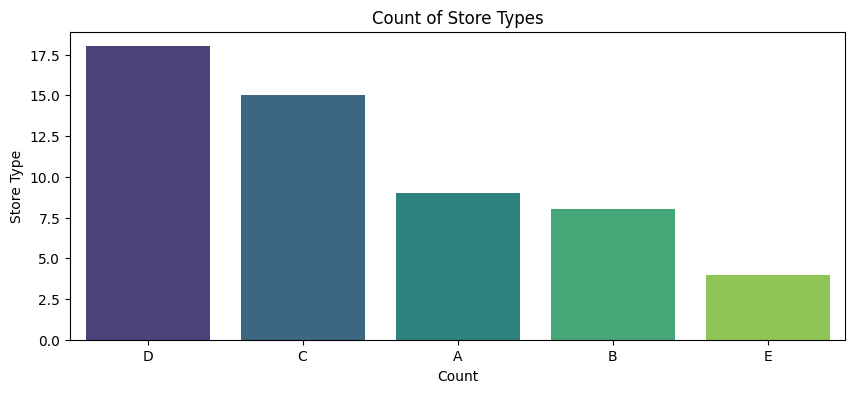

In [27]:
storetype_counts = df_3.type.value_counts()
plt.figure(figsize =(10,4))
sns.barplot(x=storetype_counts.index, y=storetype_counts.values, palette="viridis")
plt.title("Count of Store Types")
plt.xlabel("Count")
plt.ylabel("Store Type")
plt.show()


**state and city columns**

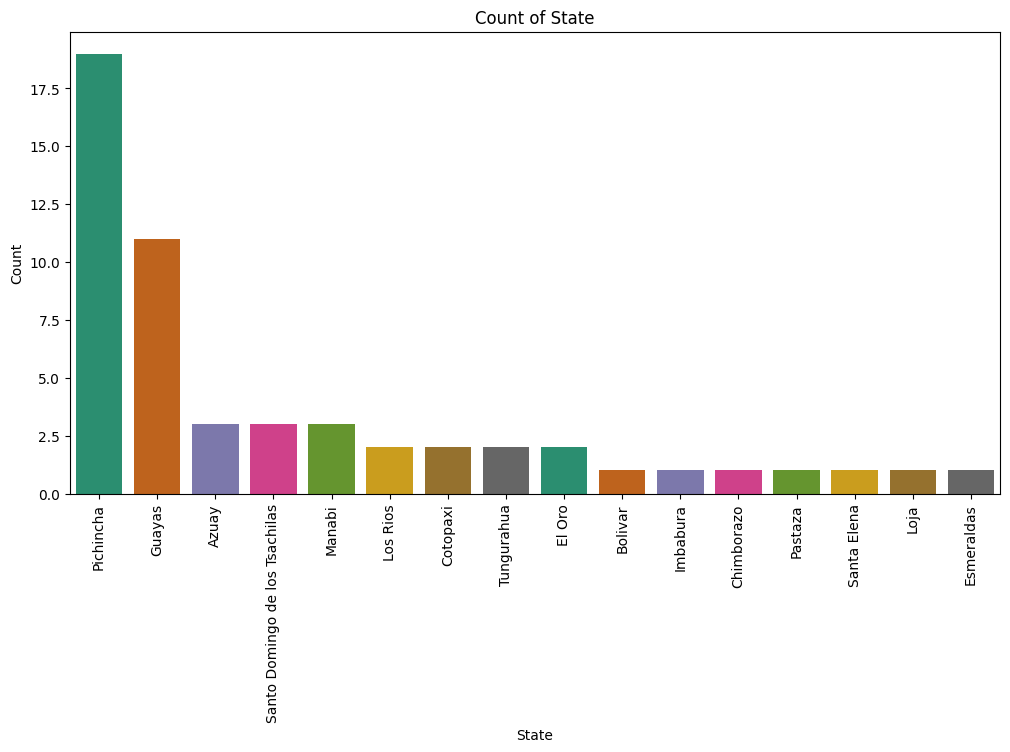

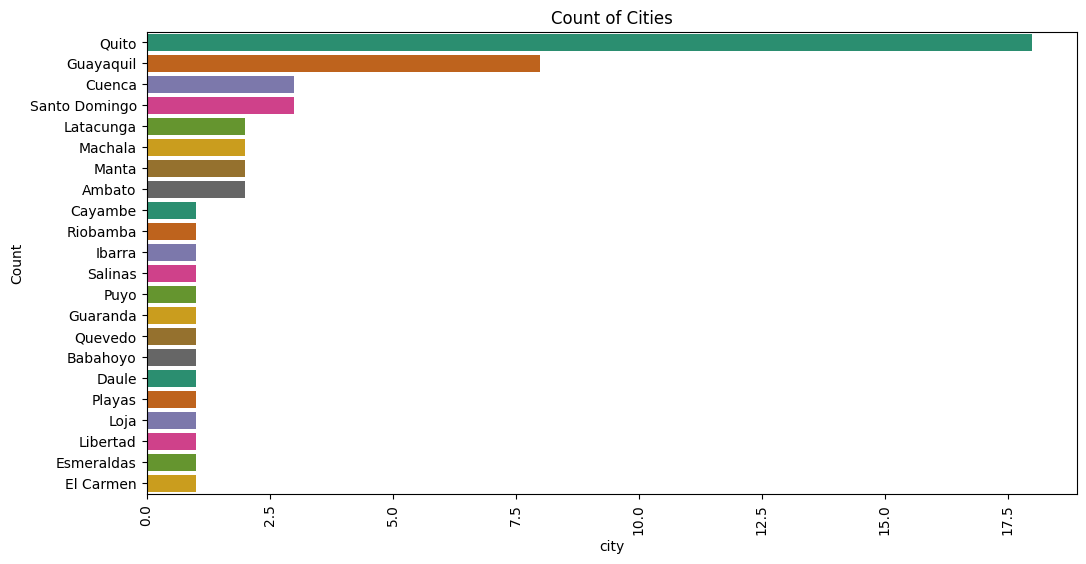

In [28]:
state_count = df_3.state.value_counts().sort_values(ascending =False)

plt.figure(figsize=(12, 6))
sns.barplot(x=state_count.index, y=state_count.values, palette='Dark2',order=state_count.index)
plt.title('Count of State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



city_count = df_3.city.value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y=city_count.index, x=city_count.values, palette='Dark2',order=city_count.index)
plt.title('Count of Cities')
plt.xlabel('city')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


**Transactions Dataset**

In [29]:
df_5.head(5)

store_nbr  transactions
date                               
2013-01-01         25           770
2013-01-02          1          2111
2013-01-02          2          2358
2013-01-02          3          3487
2013-01-02          4          1922

In [30]:
#Plot our transcation time series for insights

fig = px.line(df_5, x=df_5.index, y='transactions', title='Transaction Time Series')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

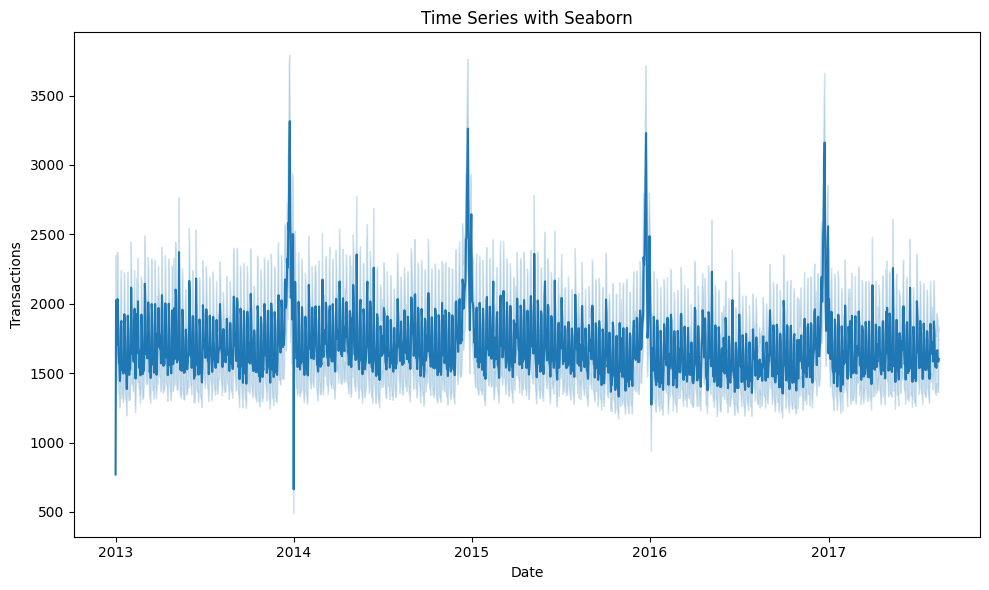

In [31]:

##using seaborn 

plt.figure(figsize=(10, 6))
sns.lineplot(df_5, x=df_5.index, y='transactions')
plt.title('Time Series with Seaborn')
plt.xlabel('Date')
plt.ylabel('Transactions')

plt.tight_layout()

plt.show()

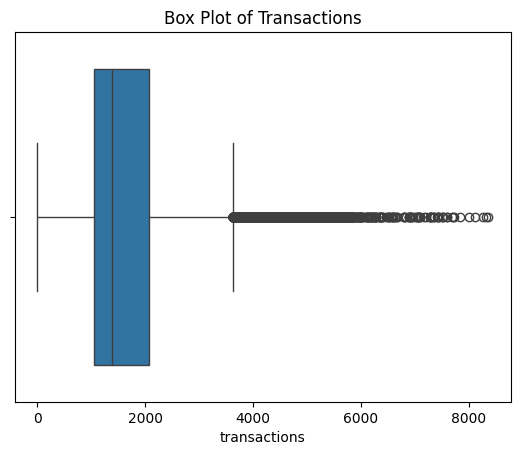

In [32]:
#check for outliers 
sns.boxplot(x=df_5['transactions'])
plt.title('Box Plot of Transactions')
plt.show()


**Observations**
- The box plot for transactions highlights the variability and distribution of transaction counts across stores. The median and quartiles provide a clear picture of where most stores fall in terms of transaction volume, while the outliers indicate stores with exceptionally high transactions.
- the time series plot shows a spike in transaction on dec 23rd of every year(seasonality).This can be attributed to Christmas season.

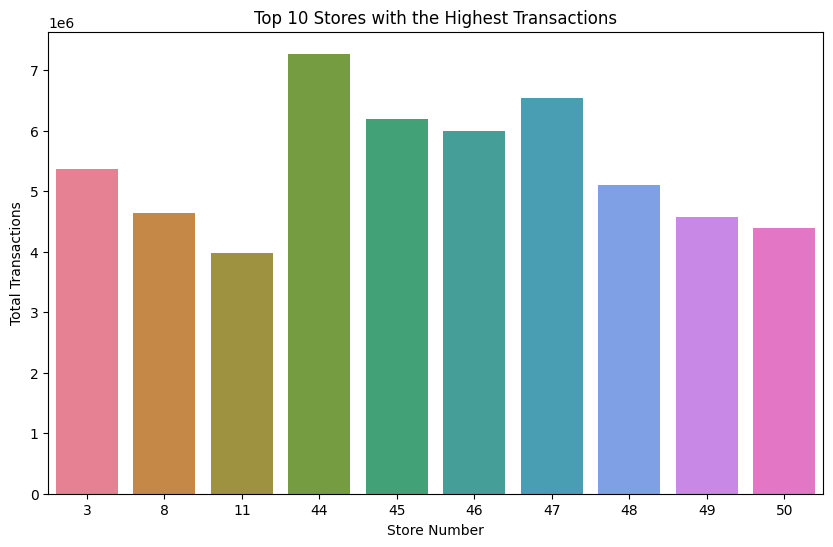

In [33]:
#Check top 10 stores with highest transactions
top_stores = df_5.groupby("store_nbr")["transactions"].sum().sort_values(ascending=False).head(10)

# Create a color palette with different colors
colors = sns.color_palette("husl", len(top_stores))

# Plot the bar plot with different colors for each bar
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stores.index, y=top_stores.values, palette=colors)
plt.title('Top 10 Stores with the Highest Transactions')
plt.xlabel('Store Number')
plt.ylabel('Total Transactions')
plt.show()

**Train Dataset**

In [34]:
df_4.head()

id  store_nbr      family  sales  onpromotion
date                                                     
2013-01-01   0          1  AUTOMOTIVE    0.0            0
2013-01-01   1          1   BABY CARE    0.0            0
2013-01-01   2          1      BEAUTY    0.0            0
2013-01-01   3          1   BEVERAGES    0.0            0
2013-01-01   4          1       BOOKS    0.0            0

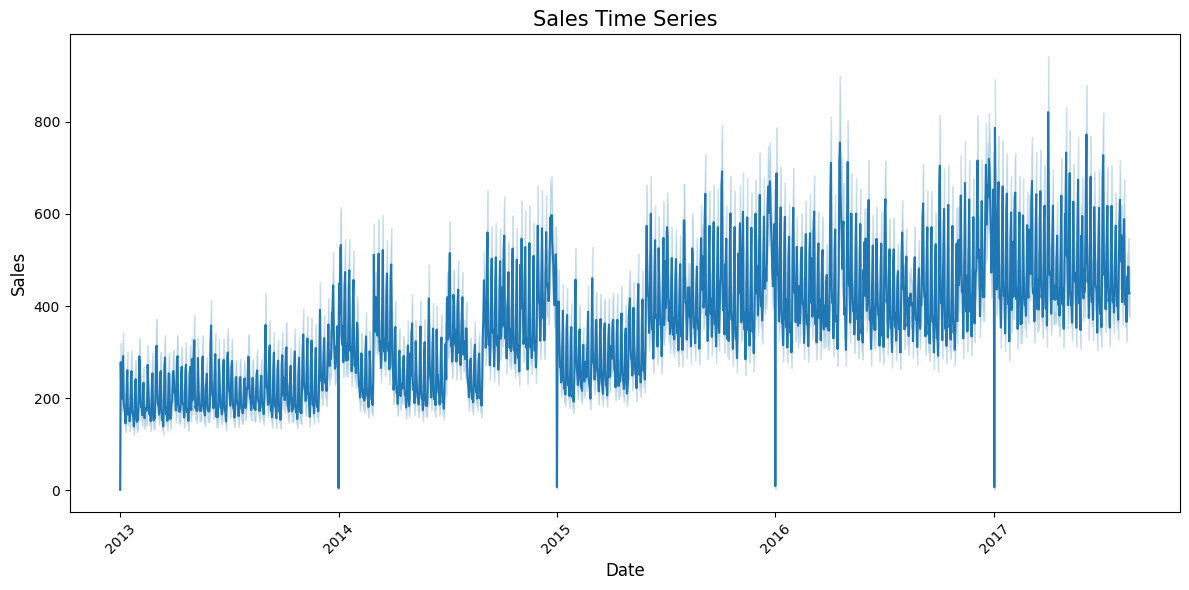

In [35]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_4, x=df_4.index, y='sales')
plt.title('Sales Time Series', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Observations**

- The sales data exhibits an upward trend over the entire period. There is a clear increase in sales from 2013 to 2017.
The trend is not perfectly smooth, indicating fluctuations in the data.Besides the seasonal fluctuations, the overall trend indicates growth in sales over the four-year period. This could suggest increasing demand or an expanding customer base.
- There appear to be regular patterns or cycles in the data, suggesting seasonality. Peaks and troughs recur at roughly regular intervals, potentially corresponding to seasonal variations
- There is significant variability in the data points. The daily sales figures show a lot of noise, which might be due to daily fluctuations in sales.
- There are noticeable sharp drops in sales that could be considered outliers. These drops might correspond to specific events, holidays, or other anomalies in the data.
- We will resample the time series to understand the underlying patterns
- We will decompose the time series into trend, seasonality, and residual components to better understand the underlying patterns

**Resampling Sales**

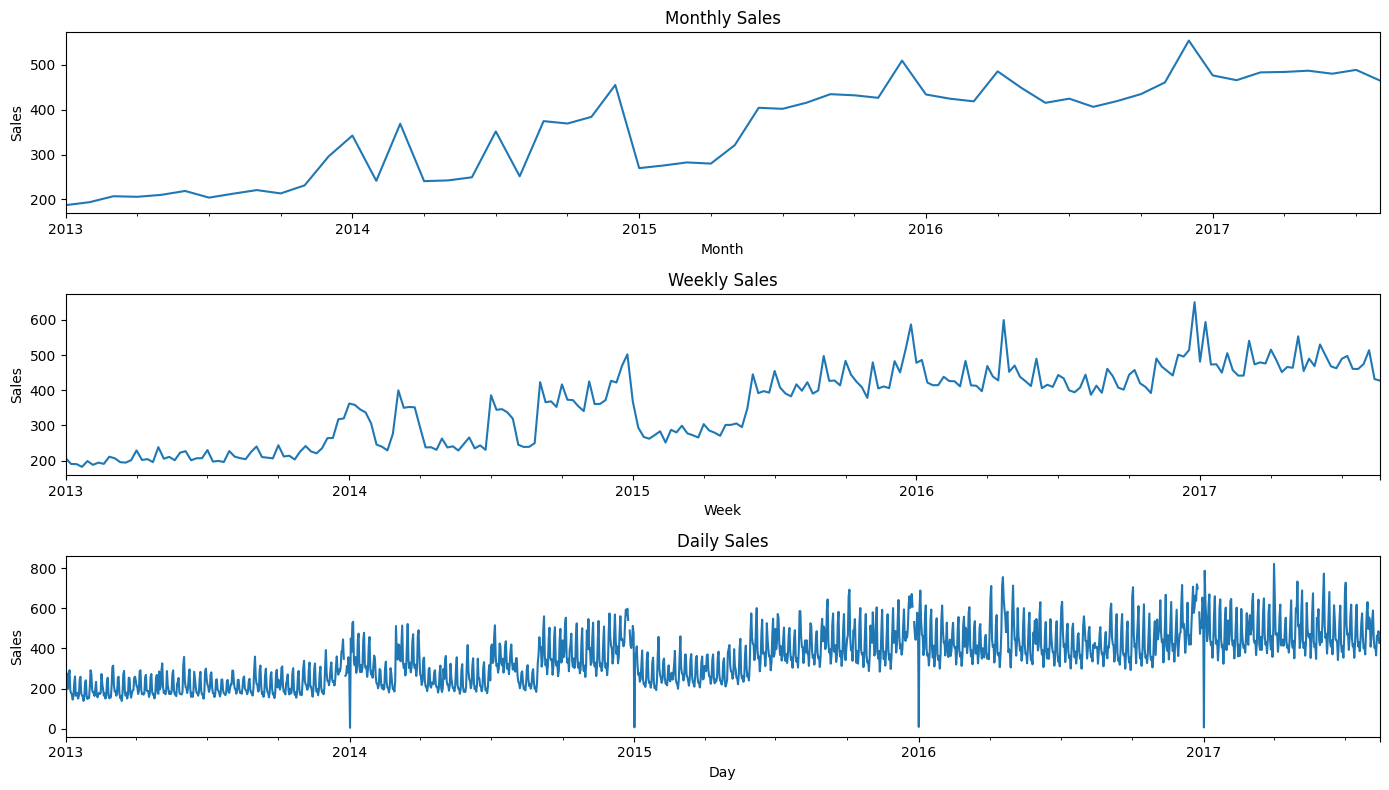

In [39]:


# Resampling the data
monthly_sales = df_4["sales"].resample("M").mean()
weekly_sales = df_4["sales"].resample("W").mean()
daily_sales = df_4["sales"].resample("D").mean()

# Plotting the resampled data
plt.figure(figsize=(14, 8))

# Monthly sales plot
plt.subplot(3, 1, 1)
monthly_sales.plot()
plt.title("Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Sales")

# Weekly sales plot
plt.subplot(3, 1, 2)
weekly_sales.plot()
plt.title("Weekly Sales")
plt.xlabel("Week")
plt.ylabel("Sales")

# Daily sales plot
plt.subplot(3, 1, 3)
daily_sales.plot()
plt.title("Daily Sales")
plt.xlabel("Day")
plt.ylabel("Sales")

# Adjusting layout
plt.tight_layout()

# Display the plots
plt.show()


**Observations**:
- The overall trend of increasing sales is evident across all three resampling frequencies, though the level of detail and smoothness differs.
- Monthly resampling smooths out short-term fluctuations and highlights long-term trends.
- Weekly resampling offers a middle ground, showing both some short-term variations and broader trends.
- Daily resampling retains the most detail but also the most noise, showing the full variability in sales.

In [ ]:
# #plot the sales time series data
# fig = px.line(df_4, x=df_4.index, y='sales', title='Sales Time Series')
# fig.update_xaxes(rangeslider_visible=True)
# fig.show()

In [ ]:
# #Plot our onpromotion series for insights

# fig = px.line(df_4, x=df_4.index, y='onpromotion', title='On Promotion Time series')
# fig.update_xaxes(rangeslider_visible=True)
# fig.show()

**Merging the Datasets**

In [42]:
def reset_date_index(dfs):
    for name, df in dfs.items():
        if df.index.name == 'date':
            df.reset_index(inplace=True)
            print(f"DataFrame: {name} - Index reset, 'date' column is now regular column")
        else:
            print(f"DataFrame: {name} - 'date' is not the index")
        print(df.head())
        print("\n")

# Call the function to reset the index if 'date' is the index
reset_date_index(dfs)


DataFrame: Holiday Dataset - Index reset, 'date' column is now regular column
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


DataFrame: Oil Dataset - Index reset, 'date' column is now regular column
        date  dcoilwtico
0 2013-01-01   93.139999
1 2013-01-02   93.139999
2 2013-01-03   92.970001
3 2013-01-04   93.120003
4 2013-01-07   93.199997


DataFrame: Stores Dataset - 'date' is not the index
   store_nbr           city                           state type  clust

In [44]:
#define a function to merge the datasets
def merge_data(df_1, df_2, df_3, df_4, df_5):
    # Merge Oil and holiday_events using date as common column
    merged_df1 = pd.merge(df_1, df_2, on='date', how='inner')
    
    # Merge the result with the transactions table using date as common column
    merged_df2 = pd.merge(merged_df1, df_5, on='date', how='inner')
    
    # Merge the result with the stores table using store_nbr as common column
    merged_df3 = pd.merge(merged_df2, df_3, on='store_nbr', how='inner')
    
    # Merge the result with the train table using date and store_nbr columns
    final_merge_df = pd.merge(merged_df3, df_4, on=['date', 'store_nbr'], how='inner')
    
    return final_merge_df

# Call the function and print the result
merged_df = merge_data(df_1, df_2, df_3, df_4, df_5)

print(merged_df.head(5))


        date   type_x    locale locale_name         description  transferred  \
0 2013-01-01  Holiday  National     Ecuador  Primer dia del ano        False   
1 2013-01-01  Holiday  National     Ecuador  Primer dia del ano        False   
2 2013-01-01  Holiday  National     Ecuador  Primer dia del ano        False   
3 2013-01-01  Holiday  National     Ecuador  Primer dia del ano        False   
4 2013-01-01  Holiday  National     Ecuador  Primer dia del ano        False   

   dcoilwtico  store_nbr  transactions     city        state type_y  cluster  \
0   93.139999         25           770  Salinas  Santa Elena      D        1   
1   93.139999         25           770  Salinas  Santa Elena      D        1   
2   93.139999         25           770  Salinas  Santa Elena      D        1   
3   93.139999         25           770  Salinas  Santa Elena      D        1   
4   93.139999         25           770  Salinas  Santa Elena      D        1   

    id      family  sales  onpromotion

- The type_x column represents the store type.
- The type_y column represents the holiday type.


In [45]:
# Renaming the columns with the appropriate names
merged_df = merged_df.rename(columns={"type_y": "store_type", "type_x": "holiday_type"})
merged_df.head()


date holiday_type    locale locale_name         description  \
0 2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
1 2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2 2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
3 2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
4 2013-01-01      Holiday  National     Ecuador  Primer dia del ano   

   transferred  dcoilwtico  store_nbr  transactions     city        state  \
0        False   93.139999         25           770  Salinas  Santa Elena   
1        False   93.139999         25           770  Salinas  Santa Elena   
2        False   93.139999         25           770  Salinas  Santa Elena   
3        False   93.139999         25           770  Salinas  Santa Elena   
4        False   93.139999         25           770  Salinas  Santa Elena   

  store_type  cluster   id      family  sales  onpromotion  
0          D        1  561  AUTOMOTIVE    0.0            0  
1          D        1  562   BABY CARE    0.0            0  
2          D        1  563      BEAUTY    2.0            0  
3          D        1  564   BEVERAGES  810.0            0  
4          D        1  565       BOOKS    0.0            0

In [46]:
#set date as index

merged_df.set_index('date', inplace=True)
merged_df.head(5)

holiday_type    locale locale_name         description  \
date                                                                
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   

            transferred  dcoilwtico  store_nbr  transactions     city  \
date                                                                    
2013-01-01        False   93.139999         25           770  Salinas   
2013-01-01        False   93.139999         25           770  Salinas   
2013-01-01        False   93.139999         25           770  Salinas   
2013-01-01        False   93.139999         25           770  Salinas   
2013-01-01        False   93.139999         25           770  Salinas   

                  state store_type  cluster   id      family  sales  \
date                                                                  
2013-01-01  Santa Elena          D        1  561  AUTOMOTIVE    0.0   
2013-01-01  Santa Elena          D        1  562   BABY CARE    0.0   
2013-01-01  Santa Elena          D        1  563      BEAUTY    2.0   
2013-01-01  Santa Elena          D        1  564   BEVERAGES  810.0   
2013-01-01  Santa Elena          D        1  565       BOOKS    0.0   

            onpromotion  
date                     
2013-01-01            0  
2013-01-01            0  
2013-01-01            0  
2013-01-01            0  
2013-01-01            0

In [47]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322047 entries, 2013-01-01 to 2017-08-15
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   holiday_type  322047 non-null  object 
 1   locale        322047 non-null  object 
 2   locale_name   322047 non-null  object 
 3   description   322047 non-null  object 
 4   transferred   322047 non-null  bool   
 5   dcoilwtico    322047 non-null  float64
 6   store_nbr     322047 non-null  int64  
 7   transactions  322047 non-null  int64  
 8   city          322047 non-null  object 
 9   state         322047 non-null  object 
 10  store_type    322047 non-null  object 
 11  cluster       322047 non-null  int64  
 12  id            322047 non-null  int64  
 13  family        322047 non-null  object 
 14  sales         322047 non-null  float64
 15  onpromotion   322047 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(8)
memory usage: 39.6+ MB


- columns like family,holiday_type,state,city,description etc will be converted to category to optimize memory usage

In [48]:

#convert the object columns to category
# List of columns to convert to category
category_columns = ['store_type', 'locale', 'locale_name', 'description','city', 'state', 'holiday_type', 'cluster', 'family']

#define a function to convert them to category
def convert_to_category(df, category_columns):
    for col in category_columns:
        df[col] = df[col].astype('category')
    return df

# Convert the columns to category using the function
merged_df = convert_to_category(merged_df, category_columns)


# Check the updated data types
print(merged_df.info())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322047 entries, 2013-01-01 to 2017-08-15
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   holiday_type  322047 non-null  category
 1   locale        322047 non-null  category
 2   locale_name   322047 non-null  category
 3   description   322047 non-null  category
 4   transferred   322047 non-null  bool    
 5   dcoilwtico    322047 non-null  float64 
 6   store_nbr     322047 non-null  int64   
 7   transactions  322047 non-null  int64   
 8   city          322047 non-null  category
 9   state         322047 non-null  category
 10  store_type    322047 non-null  category
 11  cluster       322047 non-null  category
 12  id            322047 non-null  int64   
 13  family        322047 non-null  category
 14  sales         322047 non-null  float64 
 15  onpromotion   322047 non-null  int64   
dtypes: bool(1), category(9), float64(2), int64(4)
memory usage

In [49]:
# Dropping the Id column since it will not be relevant for the visualizations
merged_df.drop(columns = ['id'], inplace = True)

**summary statistics on Merged data**

In [50]:
#descriptive statistics
merged_df.describe().T

count         mean          std        min          25%  \
dcoilwtico    322047.0    63.670748    24.846464  27.959999    44.880001   
store_nbr     322047.0    26.994672    15.595174   1.000000    13.000000   
transactions  322047.0  1734.117840  1050.335018  54.000000  1030.000000   
sales         322047.0   406.383452  1246.881240   0.000000     1.000000   
onpromotion   322047.0     3.727136    15.512095   0.000000     0.000000   

                  50%          75%            max  
dcoilwtico      51.98    94.089996     107.949997  
store_nbr       27.00    40.000000      54.000000  
transactions  1409.00  2148.000000    8359.000000  
sales           19.00   241.260505  124717.000000  
onpromotion      0.00     1.000000     716.000000

**Insights**

- The onpromotion column indicates the number of items on promotion. With a mean of 3.7271 and a median of 0, most entries have few or no items on promotion, suggesting a highly skewed distribution. The maximum value of 716 and a high standard deviation indicate the presence of outliers.
- Sales data is highly right-skewed, with the mean (406.38) much higher than the median (19). The large range (0 to 124,717) and high standard deviation (1246.88) indicate the presence of significant outliers, suggesting the data is not evenly distributed.
- The transactions data is right-skewed, as indicated by the mean (1734.12) being higher than the median (1409). The large maximum value (8359) and high standard deviation (1050.34) indicate the presence of outliers, suggesting the data is not evenly distributed.
- The dcoilwtico column represents the daily oil price. The mean oil price is around 63.63, with a standard deviation of 24.85, indicating significant variability in oil prices.The distribution is likely right-skewed given the higher upper quartile (75%) and maximum values compared to the median.
- Overall, the dataset contains a mix of evenly and unevenly distributed columns. Columns representing continuous variables (e.g., dcoilwtico, transactions, sales, onpromotion) show significant skewness and variability, suggesting uneven distribution.


**Saving the merged_df**

In [51]:
#save as csv for visualization in powebir
merged_df.to_csv('Sales_forecast_data.csv')


**Transaction distribution analysis**

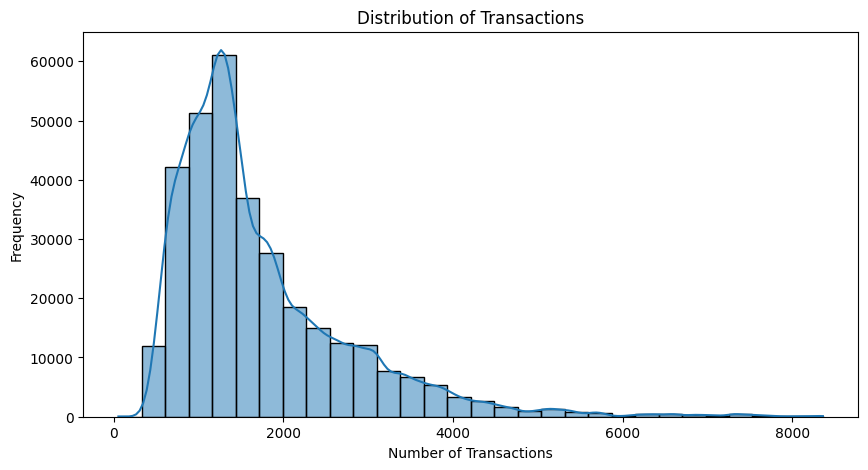

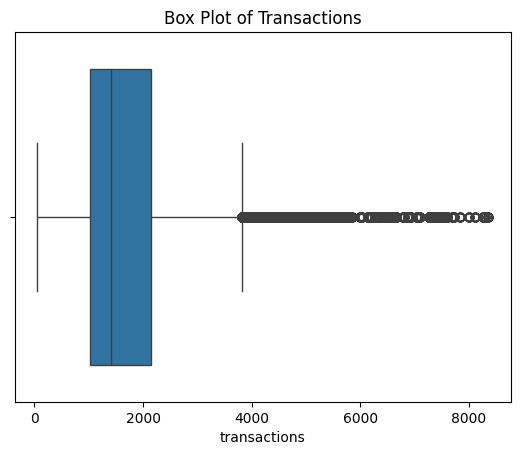

In [ ]:
# transactions distribution Analysis
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['transactions'],bins = 30, kde=True)
plt.title('Distribution of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.show()

#check for outliers 
sns.boxplot(x=merged_df['transactions'])
plt.title('Box Plot of Transactions')
plt.show()


**Observations**
- The distribution is positively skewed (right-skewed).Most of the observations are concentrated on the left side, with a long tail extending to the right which suggests that while most stores have a moderate number of transactions, there are some stores with a very high number of transactions.

- The box plot for transactions highlights the variability and distribution of transaction counts across stores. The median and quartiles provide a clear picture of where most stores fall in terms of transaction volume, while the outliers indicate stores with exceptionally high transactions.



**Bivariate Analysis**


In [52]:


# Extract year from the date column
merged_df['year'] = merged_df.index.year

# Extract month name from the date column
merged_df['month'] = merged_df.index.month_name()

# Extract day of the week from the date column (0=Monday, 6=Sunday)
merged_df['day_name'] = merged_df.index.day_name()


**Trend of Sales Over Time**
**Sales by year**


In [53]:
# sns.lineplot(merged_df, x='year', y='sales')
# plt.show()
merged_df.head()

holiday_type    locale locale_name         description  \
date                                                                
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   
2013-01-01      Holiday  National     Ecuador  Primer dia del ano   

            transferred  dcoilwtico  store_nbr  transactions     city  \
date                                                                    
2013-01-01        False   93.139999         25           770  Salinas   
2013-01-01        False   93.139999         25           770  Salinas   
2013-01-01        False   93.139999         25           770  Salinas   
2013-01-01        False   93.139999         25           770  Salinas   
2013-01-01        False   93.139999         25           770  Salinas   

                  state store_type cluster      family  sales  onpromotion  \
date                                                                         
2013-01-01  Santa Elena          D       1  AUTOMOTIVE    0.0            0   
2013-01-01  Santa Elena          D       1   BABY CARE    0.0            0   
2013-01-01  Santa Elena          D       1      BEAUTY    2.0            0   
2013-01-01  Santa Elena          D       1   BEVERAGES  810.0            0   
2013-01-01  Santa Elena          D       1       BOOKS    0.0            0   

            year    month day_name  
date                                
2013-01-01  2013  January  Tuesday  
2013-01-01  2013  January  Tuesday  
2013-01-01  2013  January  Tuesday  
2013-01-01  2013  January  Tuesday  
2013-01-01  2013  January  Tuesday

In [56]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Aggregate sales by year
sales_by_year = merged_df.groupby('year')['sales'].sum().reset_index()

# Aggregate sales by month
sales_by_month = merged_df.groupby('month')['sales'].sum().reset_index()

# Aggregate sales by day
sales_by_day = merged_df.groupby('day_name')['sales'].sum().reset_index()


# Create subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=('Total Sales by Year', 'Total Sales by Month', 'Total Sales by Day'))

# Add Yearly Sales
fig.add_trace(go.Scatter(x=sales_by_year['year'], y=sales_by_year['sales'], mode='lines+markers', name='Yearly Sales'), row=1, col=1)

# Add Monthly Sales
fig.add_trace(go.Scatter(x=sales_by_month['month'].astype(str), y=sales_by_month['sales'], mode='lines+markers', name='Monthly Sales'), row=2, col=1)

# Add Daily Sales
fig.add_trace(go.Scatter(x=sales_by_day['day_name'], y=sales_by_day['sales'], mode='lines+markers', name='Daily Sales'), row=3, col=1)

# Update layout
fig.update_layout(height=900, title_text='Sales Trends by Year, Month, and Day')
fig.update_xaxes(title_text='Year', row=1, col=1)
fig.update_xaxes(title_text='Month', row=2, col=1)
fig.update_xaxes(title_text='Day', row=3, col=1)
fig.update_yaxes(title_text='Total Sales', row=1, col=1)
fig.update_yaxes(title_text='Total Sales', row=2, col=1)
fig.update_yaxes(title_text='Total Sales', row=3, col=1)


fig.show()

**Multivariate Analysis**

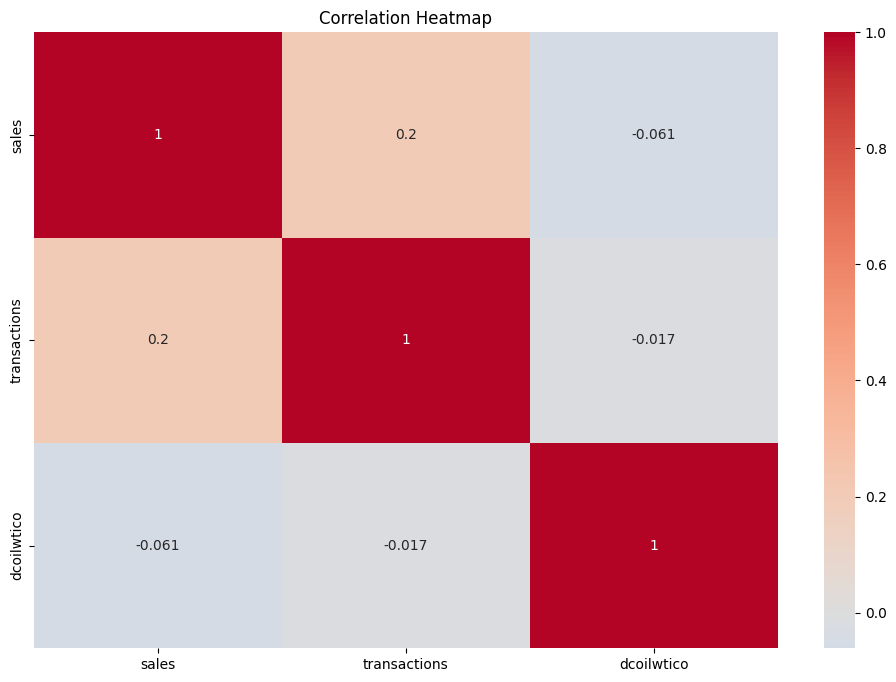

In [58]:
# Select numerical variables for correlation analysis
numeric_variables = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr = merged_df[numeric_variables].corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

- Observation

- The onpromotion variable has a noticeable positive correlation with sales, indicating promotions are likely effective in increasing sales.

- transactions and sales (correlation: 0.2): Indicates a slight positive relationship between the number of transactions and sales.As the number of transactions increases, sales tend to increase slightly as well, though the correlation is not strong.

- A weak negative correlation of approximately -0.061 is noted between "Sales" and "Dcoilwito" (Oil Prices). This indicates a minor negative relationship, where higher oil prices are slightly associated with a decrease in sales, but the correlation is not significant.
- Overall, the low correlation values reflect weak relationships between these variables.

**Stationarity Tests**

In [ ]:
# Statistical Test of the 'sales' column in the merged_df using Adfuller
sales_df = merged_df['sales']

# Perform ADF test
result = adfuller(sales_df)

# Extract the test statistics and p-value from the result
test_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the test statistics and critical values
print(f"ADF Test Statistics: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print("Reject the null hypothesis: The sales data is stationary.")
else:
    print("Fail to reject the null hypothesis: The sales data is non-stationary.")

ADF Test Statistics: -33.775289206712465
P-value: 0.0
Critical Values:
   1%: -3.4303703113855613
   5%: -2.8615489773824025
   10%: -2.566774778334627
Reject the null hypothesis: The sales data is stationary.


- The ADF test statistic (-33.775289206712465) is much smaller (more negative) than all of the critical values at the 1%, 5%, and 10% significance levels.
The p-value is less than 0.05.
Given that the ADF test statistic is more negative than the critical values and the p-value is significantly less than 0.05, we reject the null hypothesis.
- The null hypothesis for the ADF test is that the time series has a unit root, implying it is non-stationary. By rejecting the null hypothesis, we conclude that the sales data is stationary. This means that the statistical properties of the sales data, such as the mean and variance, do not change over time, making it suitable for time series modeling and forecasting techniques that assume stationarity.